In [12]:
! pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.3 MB/s eta 0:00:00


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("salader/dogs-vs-cats")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dogs-vs-cats


In [2]:
import os

# Define the train and test directories
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)  # Normalization
test_datagen = ImageDataGenerator(rescale=1./255)

# Create train and test generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'   # 2 classes: cat and dog
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [4]:
print(train_generator.class_indices)

{'cats': 0, 'dogs': 1}


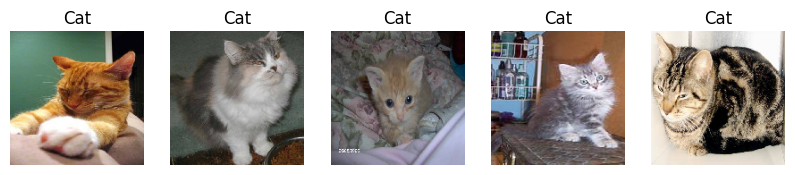

In [5]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
images, labels = next(train_generator)  # or use test_generator to see test images

# Plot the first 5 images in the batch
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])  # Display the image
    plt.axis('off')  # Turn off axis
    plt.title('Dog' if labels[i] == 1 else 'Cat')  # Title based on label
plt.show()

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Initialize the CNN
model = Sequential()

# Step 1: Convolution Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Step 2: Second Convolution Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Step 3: Flatten the layers
model.add(Flatten())

# Step 4: Fully connected layer
model.add(Dense(128, activation='relu'))

# Step 5: Output layer (binary classification: cat vs dog)
model.add(Dense(1, activation='sigmoid'))

# Print the model summary to check the layers
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,481 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
early_stopping = EarlyStopping(
    monitor='val_loss',           # The metric to monitor
    patience=3,                   # Number of epochs to wait before stopping if there's no improvement
    verbose=1,                    # Display a message when early stopping is triggered
    restore_best_weights=True     # Restore the best model weights from the epoch with the best validation loss
)


In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 168s 260ms/step - accuracy: 0.5924 - loss: 0.7940 - val_accuracy: 0.6913 - val_loss: 0.5905
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.7163 - loss: 0.5459 - val_accuracy: 0.7496 - val_loss: 0.5112
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 131ms/step - accuracy: 0.8207 - loss: 0.4005 - val_accuracy: 0.7722 - val_loss: 0.4991
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.9099 - loss: 0.2304 - val_accuracy: 0.7656 - val_loss: 0.5962
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.9732 - loss: 0.0831 - val_accuracy: 0.7548 - val_loss: 0.8232
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 89ms/step - accuracy: 0.9892 - loss: 0.0420 - val_accuracy: 0.7660 - val_loss: 1.2106
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


Hyperparameter Tuning

In [13]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()

    # Number of convolutional layers
    num_conv_layers = hp.Int("conv_layers", min_value=1, max_value=3)

    for i in range(num_conv_layers):
        filters = hp.Int(f"filters_{i}", min_value=32, max_value=128, step=32)
        kernel_size = hp.Choice(f"kernel_size_{i}", values=[3, 5])
        activation = hp.Choice(f"activation_{i}", values=["relu", "tanh"])

        if i == 0:
            model.add(Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), activation=activation,
                             input_shape=(150, 150, 3)))
        else:
            model.add(Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), activation=activation))

        # Always add pooling after each conv layer
        pool_size = hp.Choice(f"pool_size_{i}", values=[2, 3])
        model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    model.add(Flatten())

    # Dense layer
    dense_units = hp.Int("dense_units", min_value=64, max_value=256, step=64)
    dense_activation = hp.Choice("dense_activation", values=["relu", "tanh"])
    model.add(Dense(dense_units, activation=dense_activation))

    # Output layer
    model.add(Dense(1, activation="sigmoid"))

    # Compile model
    optimizer = hp.Choice("optimizer", values=["adam", "sgd", "rmsprop"])
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [14]:
# ✅ Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    directory="cnn_tuner_dir",
    project_name="cats_vs_dogs"
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Start hyperparameter search
tuner.search(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Trial 5 Complete [00h 09m 51s]
val_accuracy: 0.817799985408783

Best val_accuracy So Far: 0.8640000224113464
Total elapsed time: 00h 50m 21s
